# DCGAN

## 논문 리뷰

[DCGAN 장점]
- 대부분의 상황에서 안정적으로 학습이 됨
- word2vec과 같이 DCGAN으로 학습된 Generator가 벡터 산술 연산이 가능한 성질을 갖음    
![Alt text](img2vec.png)

- DCGAN이 학습한 필터를 시각화하여 보여줌 -> 특정 필터들이 이미지의 특정 물체를 학습했음을 보여줌  


![Alt text](filter.png)

- 성능면에서 비지도 학습 알고리즘에 비해 우수함

[APPROACH AND MODEL ARCHITECTURE]  
DCGAN은  
- Max Pooling To Strided Convolution
- Fully-Connected Layer 삭제
- BatchNormalization을 추가함 -> deep한 모델이더라도 gradient의 흐름이 잘 전달됨
- ReLU와 Leaky ReLU를 사용

[DETAILS OF ADVERSARIAL TRAINING]  

- 모델 및 옵티마이저  
![Alt text](Generator%20structure.png)  
    - mini-batch Stochastic Gradient Descent(SGD) a with batch size of 128
    - All weight: zero-centered Normal distribution with std 0.02
    - Leaky ReLU: slope 0.2
    - Optimizer: Adam (GAN에서는 momentum 사용)
    - learning late: 0.0002(0.001은 너무 커서..)
    - D's criterion= 
$\log(D(x))$*(real data*) + $\log(1 - D(G(x)))$*(fake data)*

    - G's criterion =
$\log(D(G(z)))$

- 데이터
    - LSUN
    - FACES
    - IMAGENET-1K

DCGAN에서 중요한 기준
- NOT MIMICKING TRAIN DATA -> 단순히 학습 데이터를 모방하면 안됨!
- "Walking in the latent Space" -> G의 input z의 공간인 latent Space에서 z1에서 z2로 살짝 이동한다 하더라도 급작스러운 변화가 일어나지 않고 물흐르듯 부드러운 변화를 보여줘야 한다.  
![Alt text](vecz2img.png)

## 논문 구현

### 모듈 및 데이터 다운로드

In [1]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from fastai.vision.all import * 
import torchvision.datasets as dsets
from torchvision import transforms

---

- 데이터 다운로드

- .tgz 파일 압출 풀기

``` python
path = untar_data(URLs.PETS)

import tarfile

fname = "C:/Users/default.DESKTOP-HUJV032/.fastai/archive/oxford-iiit-pet.tgz"  # 압축 파일을 지정
ap = tarfile.open(fname)      
ap.extractall("C:/Users/default.DESKTOP-HUJV032/.fastai/data/oxford-iiit-pet") # 압축 풀기
 
ap.close()  
```
---

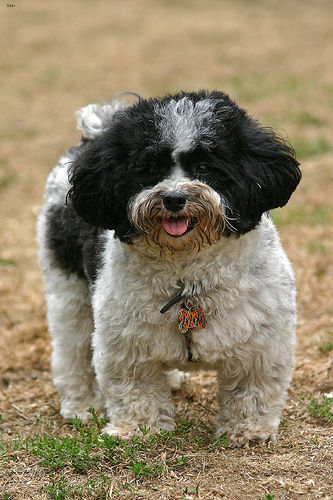

In [6]:
img = PILImage.create("C:/Users/default.DESKTOP-HUJV032/.fastai/data/oxford-iiit-pet/images/havanese_1.jpg")
img

---

- 강아지 고양이 폴더 분류 코드

In [36]:
#파일을 폴더 분류에 맞게 이동
def moveFile(src, dst):
    filelist = os.listdir(src)
    for file in filelist:
        if file[0].isupper():
            shutil.copy(os.path.join(src, file), os.path.join(dst, 'cat'))
        else:
            shutil.copy(os.path.join(src, file), os.path.join(dst, 'dog'))


``` python
src = "C:/Users/default.DESKTOP-HUJV032/.fastai/data/oxford-iiit-pet/images"
dst = "C:/Users/default.DESKTOP-HUJV032/.fastai/data/oxford-iiit-pet/"

moveFile(src, dst)
```
---

#### 채널이 1인 이미지 찾기

- 모든 이미지의 채널이 3이어야 에러가 발생하지 않아서 이를 탐색해주어야 함

In [103]:
test = ImageTransform(mean, std)
temp = []
for i in range(4988):
    temp.append(test(Image.open(d_list[i])).shape[0])


In [105]:
ntemp = pd.DataFrame(temp)
ntemp.columns=['val']
ntemp[ntemp['val']==1]

### 데이터로더 정의(데이터 셋, transform, 파일 경로 리스트 정의)

In [99]:
dog_path = "C:/Users/default.DESKTOP-HUJV032/.fastai/data/oxford-iiit-pet/dog"
dog_list = os.listdir(dog_path)

cat_path = "C:/Users/default.DESKTOP-HUJV032/.fastai/data/oxford-iiit-pet/cat"
cat_list = os.listdir(cat_path)

In [100]:
d_list = []
for dog in dog_list:
    d_list.append("C:/Users/default.DESKTOP-HUJV032/.fastai/data/oxford-iiit-pet/dog/" + str(dog))

c_list = []
for cat in cat_list:
    c_list.append("C:/Users/default.DESKTOP-HUJV032/.fastai/data/oxford-iiit-pet/cat/" + str(cat))


In [101]:
class ImageTransform():
    """이미지 전처리 클래스"""
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [107]:
class GAN_Img_Dataset(data.Dataset):
    """Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''이미지 개수 반환'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리된 이미지를 Tensor 형식 데이터로 변환'''
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 이미지 전처리
        img_transformed = self.transform(img)
        img_transformed = img_transformed.type(torch.FloatTensor)
        return img_transformed

In [108]:
# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=d_list, transform=ImageTransform(mean, std))

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [109]:
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 3, 64, 64])


### Generator 및 Discriminator 정의

In [110]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");device

device(type='cuda', index=0)

In [111]:
class Generator(nn.Module):
    def __init__(self, z_dim = 20, image_size = 64):
        super(Generator, self).__init__()

        # layer1 -> W(H) * 4
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size = 4, stride = 1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))
        
        # layer2 -> W(H) * 2
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size = 4, stride = 2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size = 4, stride = 2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size = 4, stride = 2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 3, kernel_size= 4, stride=2, padding=1), # 흑백 이미지이므로 출력 차원을 1으로 지정한 것
            nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        out = out.type(torch.FloatTensor)
        return out

In [112]:
G = Generator(z_dim=20, image_size=64).to(device)

In [113]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, image_size, kernel_size=4,stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        out = out.type(torch.FloatTensor)
        return out

In [114]:
D = Discriminator(z_dim=20, image_size=64).to(device)

In [115]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")

네트워크 초기화 완료


### 모델 훈련

In [116]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = 64

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)
            
            
            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 진짜 이미지 판정
            d_out_real = D(imges)

            # 가짜 이미지 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1).to(device)
            fake_images = G(input_z)
            d_out_fake = D(fake_images.to(device))

            # 오차를 계산
            d_loss_real = criterion(d_out_real.view(-1).to(device), label_real.float())
            d_loss_fake = criterion(d_out_fake.view(-1).to(device), label_fake.float())
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # 2. Generator 학습
            # --------------------
            # 가짜 이미지 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1).to(device)
            fake_images = G(input_z)
            d_out_fake = D(fake_images.to(device))

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1).to(device), label_real.float().to(device))

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D

In [ ]:
num_epochs = 1000
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

### 생성이미지 확인(epoch 1000일 때의 결과)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

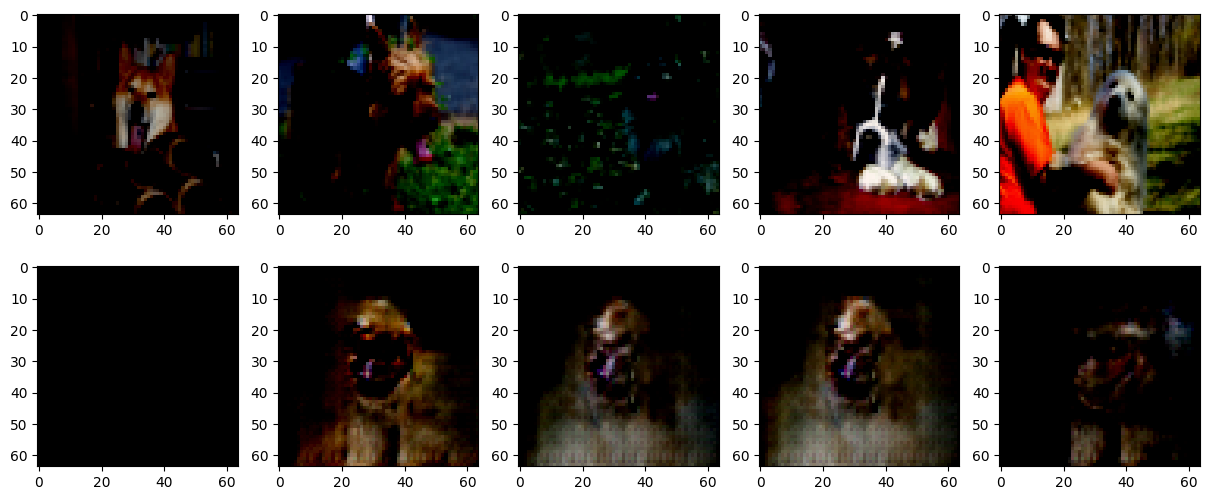

In [149]:
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

G_update.eval()
fake_images = G_update(fixed_z.to(device))
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  

# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(torch.einsum('cij -> ijc', imges[i]).cpu().detach().numpy())

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(torch.einsum('cij -> ijc', fake_images[i]).cpu().detach().numpy())